# Introduction

This notebook gives a quick tour of the `schroedinger` sub-module, which allows us to solve the time-independent Schroedinger equation for 1-, 2-, and 3-dimensions.

In addition to our typical pyiron jupyter setup, here we use the `k3d` package for plotting the 3D results. This requires the following (one-time) setup in the shell where you run jupyter:

```bash
jupyter nbextension install --py --sys-prefix k3d
jupyter nbextension enable --py --sys-prefix k3d
```

In [1]:
from pyiron_continuum import Project
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pr = Project('schroedinger_tutorial')
pr.remove_jobs(silently=True)

0it [00:00, ?it/s]

# Basic tools

Underlying the numerics necessary for the Schroedinger class, we introduce two new tools: meshes and potentials.

The `RectMesh` class allows us to quickly build rectangular mesh prisms with uniform grid spacing (which is independent in each cartesian direction). We also have a `Potential` class which maps our mesh onto a scalar field. In particular, here we'll use two children of the `Potential` class which give square and sinusoidal wells.

The rest of this section explores the mesh behaviour a little bit. If you want, you can jump straight to the next section where we actually solve the Schroedinger equation.

In [3]:
mesh = pr.continuum.mesh.RectMesh(
    bounds=[
        [0, 1],
        [1, 3]
    ],
    divisions=[100, 400]
)

In [4]:
mesh.mesh.shape, mesh.lengths

((2, 100, 400), array([1, 2]))

In [5]:
potential = pr.continuum.schroedinger.potential.Sinusoidal(n_waves=3)

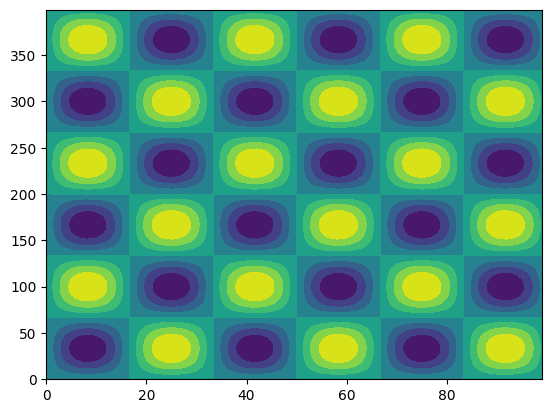

In [6]:
plt.contourf(potential(mesh).T)

We can also make tools on top of the mesh for performing discrete operations -- right now there's just the Laplacian operator (`(l, m, n) -> (l, m, n)`), but in principle things like grad (`(l, m, n) -> (d, l, m, n)`), div (`(d, l, m, n) -> (l, m, n)`), curl (`(d, l, m, n) -> (d, l, m, n)`) etc. should be easy enough to implement. (Gradient, including non-uniform spacing, is already part of numpy, but none of the others AFAIK.)

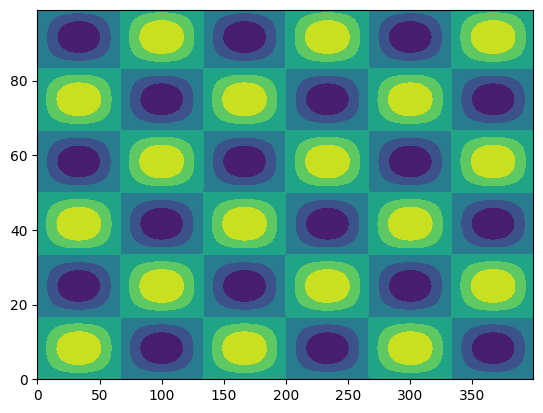

In [7]:
plt.contourf(mesh.laplacian(potential))

(2, 100, 400) (100, 400)


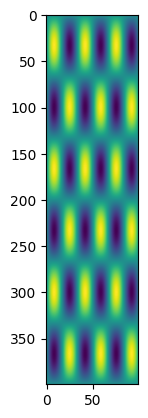

In [8]:
print(mesh.shape, potential(mesh).shape)
plt.imshow(mesh.laplacian(potential(mesh)).T)

Why not just `scipy.ndimage.laplacian`?

Pros:
- Already exists
- Has more options than just periodic for boundary conditions

Con:
- Does not make reference to underlying mesh -- i.e. not allowed to provide different mesh spacings in different directions

# 1D Square Well

First, let's play with the traditional example of a square well. We will run into numeric issues if we try to make our potential truly infinite, but you can mimic this by increasing the depth of the well to be very, very deep if you want.

Other than the potential we provide a mesh, the number of states for which we want to solve, and the mass of the particle we're solving for. After that it's as simple as calling the `run` method!

In [9]:
job1d_square = pr.continuum.job.TISE('tise1d_square', delete_existing_job=True)
job1d_square.input.potential = pr.continuum.schroedinger.potential.SquareWell(depth=10)
job1d_square.input.mesh = pr.continuum.mesh.RectMesh(bounds=30, divisions=400)
job1d_square.input.n_states = 4
job1d_square.run()

The job tise1d_square was saved and received the ID: 7


We can plot the solutions individually, e.g. the first excited state:

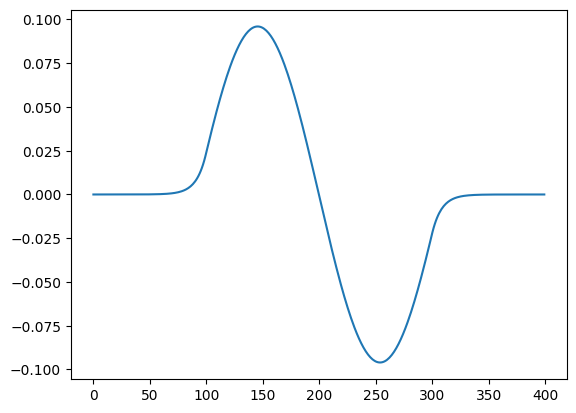

In [10]:
job1d_square.plot_1d.psi(1);

We also have a nice helper function for plotting all the states found alongside the potential, shifted by their eigenenergy. As long as your potential well depth is reasonable, this looks quite nice:

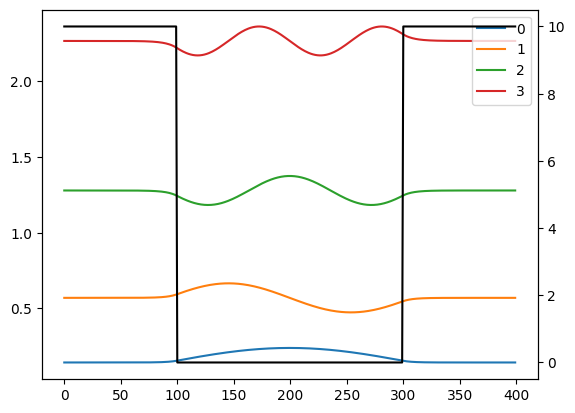

In [11]:
job1d_square.plot_1d.levels();

We can also consider the particle in a thermalized superposition of the states,

$\rho(T) = \frac{1}{Z} \sum_i w_i(T) \rho_i$,

where $w_i(T) = \exp(-E_i / k_B T)$ is the Boltzmann weighting and $Z = \sum_i w_i$ is the partition function.

This lets us look at the probability density at a given temperature:

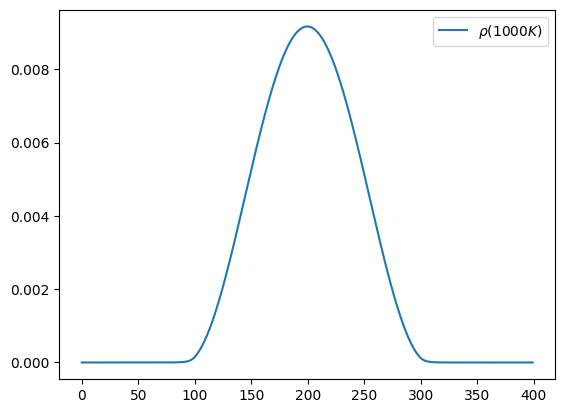

In [12]:
T = 1000
fig, ax  = plt.subplots()
job1d_square.plot_1d.boltzmann_rho(T, ax=ax, label=f'$\\rho({T}K)$')
plt.legend();

We might also want to loop over a variety of temperatures to peek at the thermal broadening of the expected state. Remember to keep an eye on the occupation probability for your highest-energy state! If this gets too large, you should probably go back and calculate more states.

T = 1000K) Highest state occupation is 1.93E-11
T = 5000K) Highest state occupation is 4.97E-03
T = 10000K) Highest state occupation is 4.33E-02


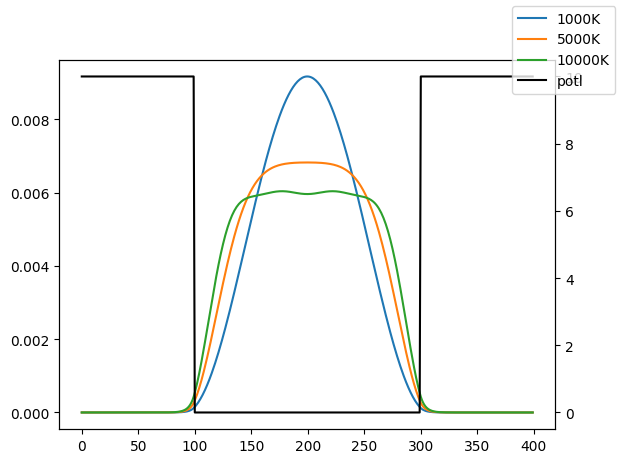

In [13]:
fig, ax  = plt.subplots()
job1d_square.plot_1d.potential(ax=ax.twinx(), color='k', label='potl')
for T in [1000, 5000, 10000]:
    print(f'T = {T}K) Highest state occupation is {job1d_square.output.get_boltzmann_occupation(T)[-1]:.2E}')
    job1d_square.plot_1d.boltzmann_rho(T, ax=ax, label=f'{T}K')
fig.legend();

# 1D Sine Potential

We can quickly repeat the same attack for a periodic sinusoid.

In [14]:
job1d_sin = pr.continuum.job.TISE('tise1d_sin', delete_existing_job=True)
job1d_sin.input.potential = pr.continuum.schroedinger.potential.Sinusoidal(amplitude=2)
job1d_sin.input.mesh = pr.continuum.mesh.RectMesh(bounds=30, divisions=400)
job1d_sin.input.n_states = 4
job1d_sin.run()

The job tise1d_sin was saved and received the ID: 8


In [15]:
job1d_sin.output.energy

array([-1.6019267 , -0.82857988, -0.10344704,  0.56776283])

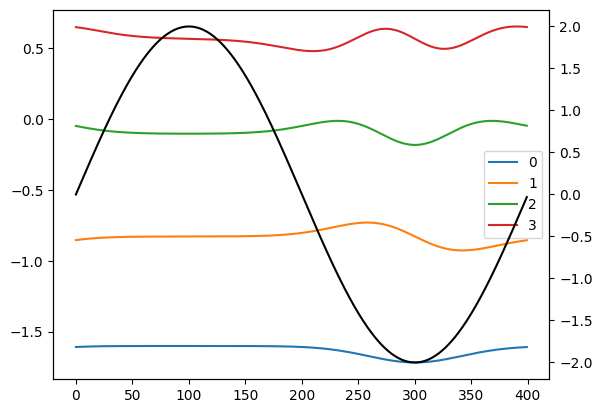

In [16]:
job1d_sin.plot_1d.levels();

T = 1000K) Highest state occupation is 1.2E-11
T = 5000K) Highest state occupation is 5.4E-03
T = 10000K) Highest state occupation is 4.8E-02


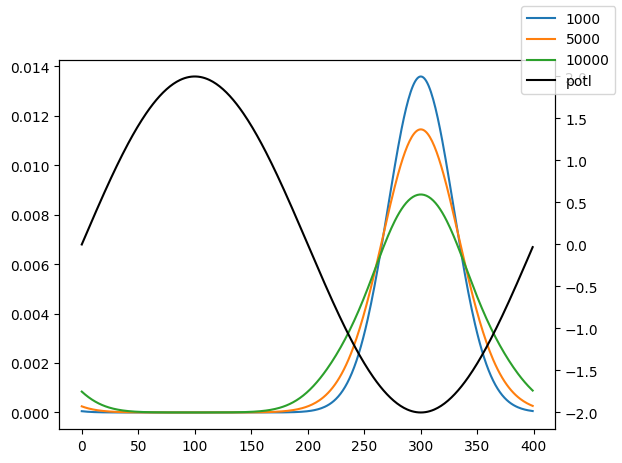

In [17]:
fig, ax  = plt.subplots()
job1d_sin.plot_1d.potential(ax=ax.twinx(), label='potl', color='k')
for T in [1000, 5000, 10000]:
    print(f'T = {T}K) Highest state occupation is {job1d_sin.output.get_boltzmann_occupation(T)[-1]:.1E}')
    job1d_sin.plot_1d.boltzmann_rho(T, ax=ax, label=f'{T}')
fig.legend();

By examining the thermally weighted probability densities, we can see that we transition towards the classical solution as we increase temperature -- be careful though, as in the last figure you can see the importance of including enough states that the highest energy levels are not over-occupied!

Highest energy state occupation = 4.4922175940548375e-110


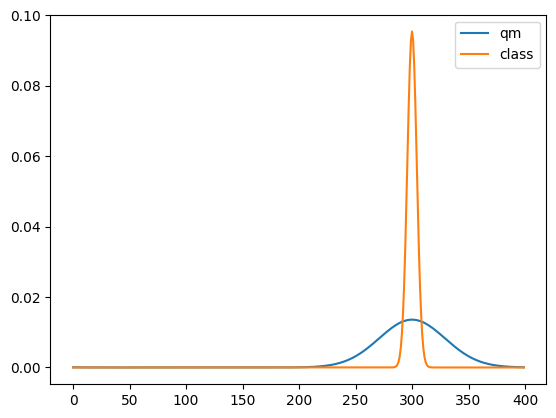

Highest energy state occupation = 1.1619597359544045e-11


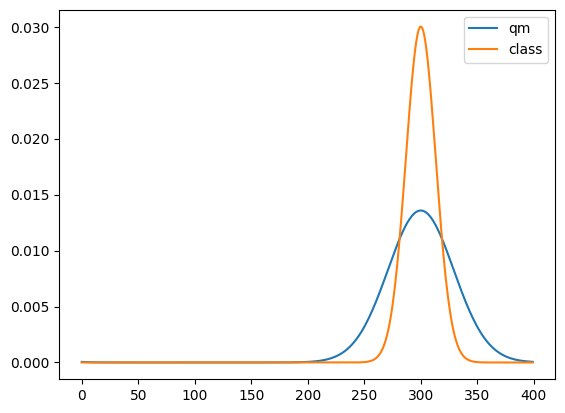

Highest energy state occupation = 0.04845976562673267


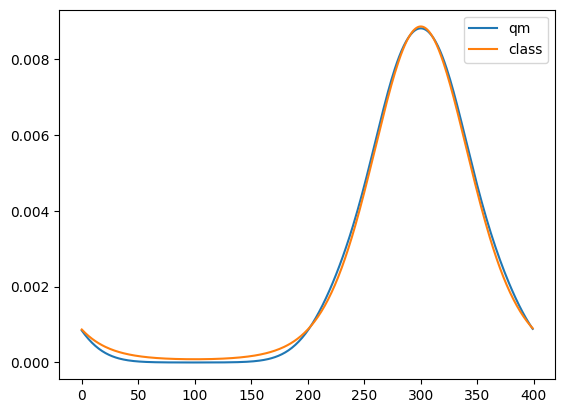

Highest energy state occupation = 0.22010791505043886


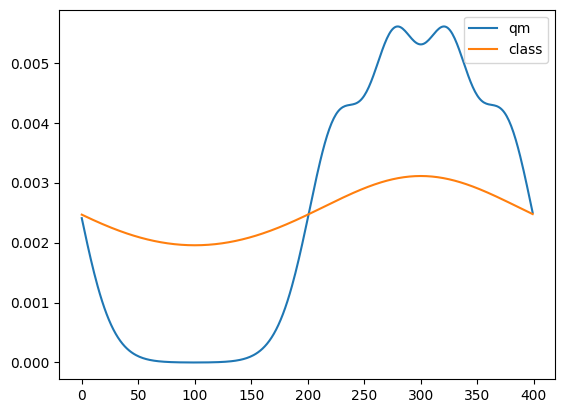

In [18]:
from scipy.constants import physical_constants
KB = physical_constants['Boltzmann constant in eV/K'][0]

for T in [100, 1000, 10000, 100000]:
    max_occ = job1d_sin.output.get_boltzmann_occupation(T)[-1]
    print(f'Highest energy state occupation = {max_occ}')
    rho_qm = job1d_sin.output.get_boltzmann_rho(T)
    V = job1d_sin.potential(job1d_sin.mesh)
    rho_classical = np.exp(- V / (KB * T))
    rho_classical /= rho_classical.sum()
    plt.plot(rho_qm, label='qm')
    plt.plot(rho_classical, label='class')
    plt.legend()
    plt.show()

You can go back and rerun this job with an increased number of states to see the effect at the highest temperature above.

# 2D Sine Potential

Working in higher dimensions is as simple as passing in a higher dimensional mesh. This in turn is as simple as providing the `RectMesh` object with bounds for each dimension. Note that the divisions will automatically scale up to the dimensionality of the bounds.

In [19]:
job2d_sin = pr.continuum.job.TISE('tise2d_sin', delete_existing_job=True)
job2d_sin.input.potential = pr.continuum.schroedinger.potential.Sinusoidal(n_waves=2, amplitude=2)
job2d_sin.input.mesh = pr.continuum.mesh.RectMesh(bounds=[30, 30], divisions=[100, 120])
nx, ny = 4, 3  # Just a convenient decomposition of the number of states for later plotting
job2d_sin.input.n_states = nx * ny
job2d_sin.run()

The job tise2d_sin was saved and received the ID: 9


In [20]:
job2d_sin.output.energy

array([-1.88713499, -1.87087058, -1.87087058, -1.87087056, -1.87087056,
       -1.87063534, -1.87063534, -1.85413561, -0.10149764, -0.10149764,
       -0.08501105, -0.08498699])

Higher dimensional data is a bit less friendly for plotting, so we don't have a nice overlap of potentials and wavefunctions, but we can look at them one at a time

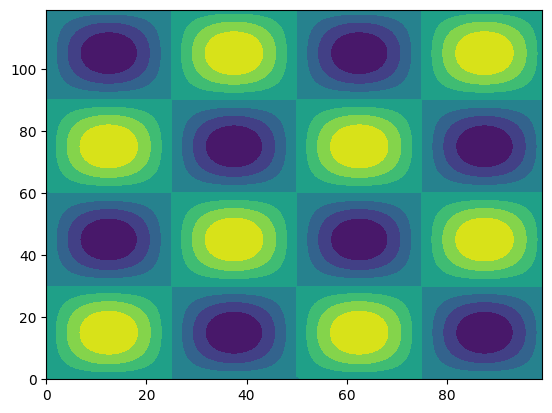

In [21]:
job2d_sin.plot_2d.potential();

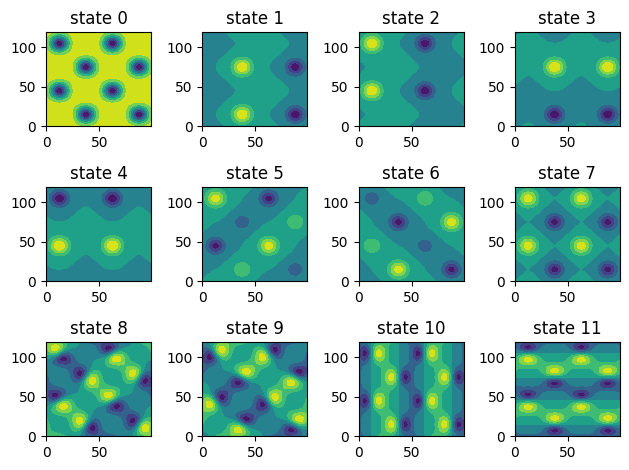

In [22]:
fig, axes = plt.subplots(ncols=nx, nrows=ny)
flaxes = axes.flatten()
for i in range(job2d_sin.input.n_states):
    job2d_sin.plot_2d.psi(i, ax=flaxes[i])  # also try `psi`-->`rho` to plot density!
    flaxes[i].set_title(f'state {i}')
fig.tight_layout()
plt.show()

And of course we can still look at a thermal average (although, again, overlaying multiple temperatures is not so easy)

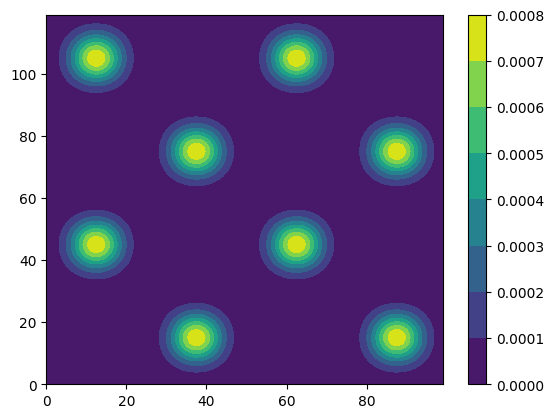

In [23]:
fig, ax = plt.subplots()
_, img = job2d_sin.plot_2d.boltzmann_rho(500, ax=ax)
plt.colorbar(img, ax=ax)
plt.show()

# 2D Random Potential

In this notebook we mostly use potentials that inherit from the `Potentials` class, which is great when you have a single parameterized potential you want to re-use many times. However, you might have a single potential that you know numerically on your mesh and you just want to use that. This is fine, as we allow the potential to be provided as a numpy array. Please note that if it doesn't have dimensionality matching a scalar field on your mesh (i.e. dimension `(l, m, n)`if your mesh has dimension `(d, l, m, n)`) then you will run into trouble.

For this example, let's just make a silly potential that's completely random noise.

In [24]:
def my_potential(mesh, scale=5):
    return np.random.rand(*mesh.shape[1:])

In [25]:
job2d_rand = pr.continuum.job.TISE('tise2d_rand', delete_existing_job=True)
job2d_rand.input.mesh = pr.continuum.mesh.RectMesh(bounds=[30, 30], divisions=100)
job2d_rand.input.potential = my_potential(job2d_rand.mesh)
nx, ny = 4, 3  # Just a convenient decomposition of the number of states for later plotting
job2d_rand.input.n_states = nx * ny
job2d_rand.run()

The job tise2d_rand was saved and received the ID: 10


In [26]:
job2d_rand.output.energy

array([0.4986013 , 0.65987961, 0.66457576, 0.66614158, 0.67247124,
       0.82702696, 0.83107964, 0.83294091, 0.84104769, 1.16099077,
       1.16440387, 1.16791129])

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.contour.QuadContourSet at 0x7f0511e3d570>)

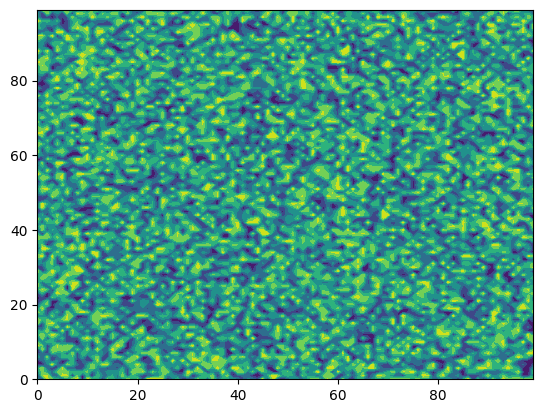

In [27]:
job2d_rand.plot_2d.potential()

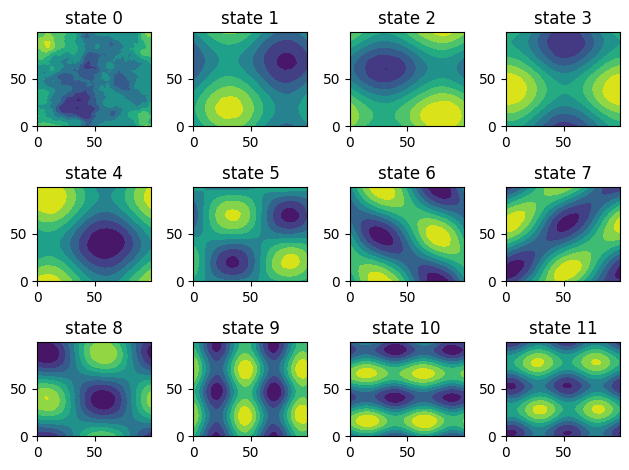

In [28]:
fig, axes = plt.subplots(ncols=nx, nrows=ny)
flaxes = axes.flatten()
for i in range(job2d_rand.input.n_states):
    job2d_rand.plot_2d.psi(i, ax=flaxes[i])  # also try `psi`-->`rho` to plot density!
    flaxes[i].set_title(f'state {i}')
fig.tight_layout()
plt.show()

The low-energy states are closely linked to the noise that we see in our potential, but as we get to higher energy they become more wavelike as they are more like a free electron solution

# 3D Cube Potential

Finally, we can also run in 3D. The only real words of warning are that plotting requires the `k3d` library, which is not standard, and that you may need to be careful about how dense your grid is to avoid computational expense. Otherwise it's the same old song and dance.

In [29]:
job3d_cube = pr.continuum.job.TISE('tise3d_cube', delete_existing_job=True)
job3d_cube.input.potential = pr.continuum.schroedinger.potential.SquareWell(depth=5)
job3d_cube.input.mesh = pr.continuum.mesh.RectMesh(bounds=[25, 25, 25], divisions=50)
job3d_cube.input.n_states = 6
job3d_cube.run()

The job tise3d_cube was saved and received the ID: 11


In [30]:
job3d_cube.output.energy

array([0.55092013, 1.09803538, 1.09803538, 1.09803538, 1.643684  ,
       1.643684  ])

Our potential is pretty boring, it's just a cube:

In [31]:
_, plot = job3d_cube.plot_3d.potential()
plot.display()

Output()

But very pleasingly our states really start to look like molecular orbitals now that we're working in 3D, even though our potential is the not-so-physical cubic well!

In [32]:
_, plot = job3d_cube.plot_3d.psi(0, level=0.005)
plot.display()

Output()

# Exercise

We are solving analytic equations on a discrete mesh -- this can lead to errors in our final result. Re-run the jobs at different mesh densities and plot the ground state energy as a function of mesh divisions. How many divisions are required to get the energy converged to within 0.01 eV? (You may wish to start this exercise with the 1D system while you're writing your code, since it will run much faster.)

In [33]:
pr.remove(enable=True)

  0%|          | 0/5 [00:00<?, ?it/s]